In [88]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import shutil
import torch
import random

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "6" 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [97]:
velum_path = '../../../01_data_OTE'
velum_problematic = os.path.join(velum_path, 'images')

def detect_lens_flare(image, threshold=220):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    _, s, v = cv2.split(hsv)
    mask = np.logical_and(v > threshold, s < 30)
    bright_pixels = np.sum(mask)
    h, w, _ = image.shape
    ratio = bright_pixels / (h * w)
    return mask, ratio

def visualize_lens_flare(image_path, sample_size=10):
    image_files = random.sample(os.listdir(image_path), min(sample_size, len(os.listdir(image_path))))
    
    for i in image_files:
        image = cv2.imread(os.path.join(image_path, i))
        if image is None:
            print(f"이미지를 불러올 수 없습니다: {i}")
            continue
          
        flare_mask, ratio = detect_lens_flare(image)
        flare_mask = np.stack([flare_mask] * 3, axis=-1)
        masked_image = np.where(flare_mask, [0, 255, 0], image)
        alpha = 0.5
        result = cv2.addWeighted(image, 1 - alpha, masked_image, alpha, 0, dtype=cv2.CV_32F).astype(np.uint8)

        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        print("ratio: ", ratio)
        plt.show()

ratio:  0.005931854248046875


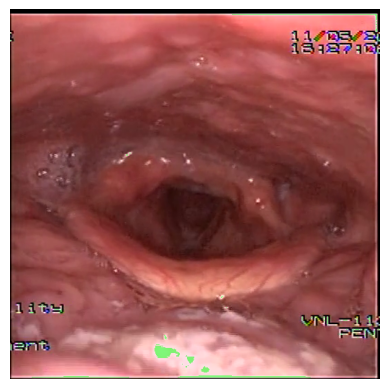

ratio:  0.11797714233398438


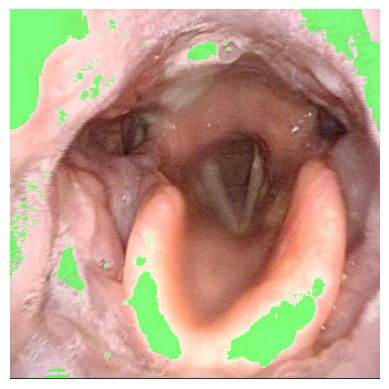

ratio:  0.001094818115234375


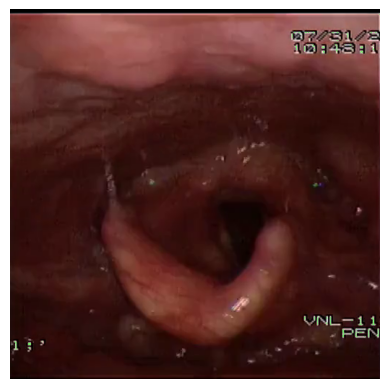

ratio:  0.2930641174316406


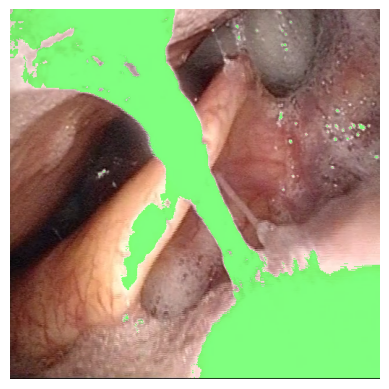

ratio:  0.024066925048828125


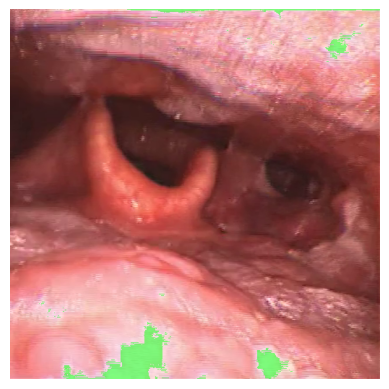

ratio:  0.00373077392578125


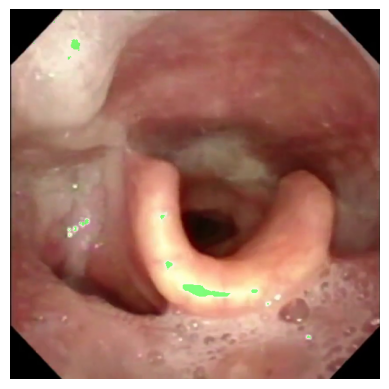

ratio:  0.37316131591796875


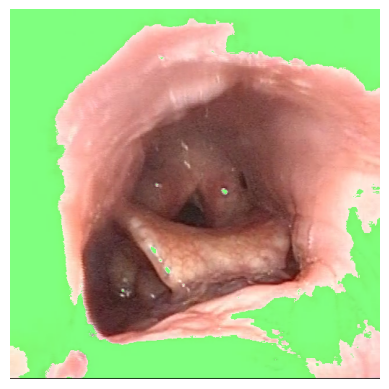

ratio:  0.2758827209472656


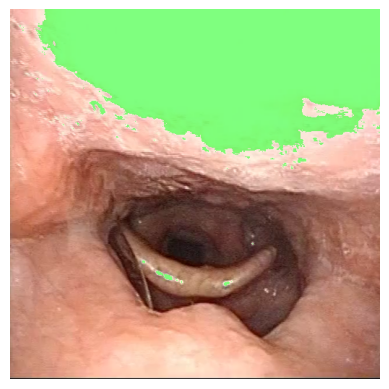

ratio:  0.1116180419921875


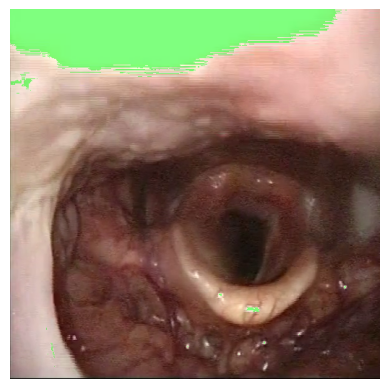

ratio:  0.02118682861328125


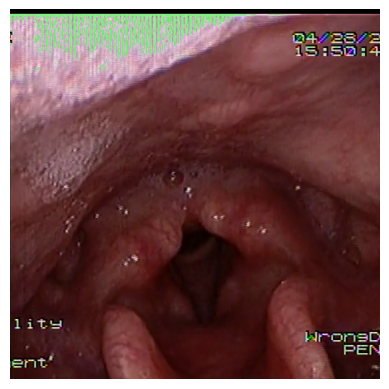

In [98]:
visualize_lens_flare(velum_problematic)

In [99]:
def transfer_img_file(image_path, output_path, threshold=0.14):
  # 총 픽셀에 10프로 기준으로 빛번짐 픽셀이 10프로 넘어가면 제외하고 이하인 데이터들만 이동 시키는 함수
  # threshold 조정
    for i in os.listdir(image_path):
        image = cv2.imread(os.path.join(image_path, i))
        if image is None:
            print(f"이미지를 불러올 수 없습니다: {i}")
            continue

        _, ratio = detect_lens_flare(image)
        # print(f"{i}의 빛 번짐 비율: {ratio}")  # ratio 값을 출력하여 조건 만족 여부 확인

        if ratio <= threshold:
            shutil.copy(os.path.join(image_path, i), os.path.join(output_path, i))

In [101]:
transfer_img_file(velum_problematic, "/home/gil/gcubme_ai2/Workspace/YS_Baik/8_NIA_DISE_synthetic/01_synthetic/01_data_OTE_filtering/images")

In [104]:
source_image_path = "/home/gil/gcubme_ai2/Workspace/YS_Baik/8_NIA_DISE_synthetic/01_synthetic/01_data_OTE_filtering/images"
source_mask_path = '../../../01_data_OTE/masks'
destination_mask_path = "/home/gil/gcubme_ai2/Workspace/YS_Baik/8_NIA_DISE_synthetic/01_synthetic/01_data_OTE_filtering/masks"

if not os.path.exists(destination_mask_path):
    os.makedirs(destination_mask_path)

for image_file in os.listdir(source_image_path):
    mask_file_path = os.path.join(source_mask_path, image_file)
    destination_file_path = os.path.join(destination_mask_path, image_file)
    
    if os.path.exists(mask_file_path):
        try:
            shutil.copy(mask_file_path, destination_file_path)
        except Exception as e:
            print(f"{image_file} 파일 복사 중 오류 발생: {e}")
    else:
        print(f"{image_file}에 해당하는 마스크 파일이 {source_mask_path}에 없습니다.")

Thumbs.db에 해당하는 마스크 파일이 ../../../01_data_OTE/masks에 없습니다.


* OTE 4 class만

In [114]:
import os
import pandas as pd

# 파일 경로 설정
csv_path = '../../../output.csv'
mask_dir = '../../../01_data_OTE_filtering_max/images'

# CSV 파일에서 'filename' 열 읽기 (확장자 제외)
df = pd.read_csv(csv_path)
csv_filenames = set(df['filename'].astype(str).str.replace('.png', '', regex=False))

# masks 디렉토리 내의 파일명 가져오기 (확장자 제외)
mask_files = os.listdir(mask_dir)
mask_file_roots = {os.path.splitext(filename)[0] for filename in mask_files}

# CSV 파일에 없는 파일명을 찾아 삭제
files_to_delete = mask_file_roots - csv_filenames

for filename_root in files_to_delete:
    file_path = os.path.join(mask_dir, filename_root + '.png')
    if os.path.exists(file_path):
        try:
            os.remove(file_path)
            # print(f"{filename_root}.png 파일을 삭제했습니다.")
        except Exception as e:
            print(f"{filename_root}.png 파일을 삭제하는 중 오류가 발생했습니다: {e}")